In [124]:
short_period = 100
long_period = 200
bb_period = 200
atr_period = 14
commission_percentage = 0.001
stop_loss_multiplier = 2
amount_invested = 1000
leverage = 1

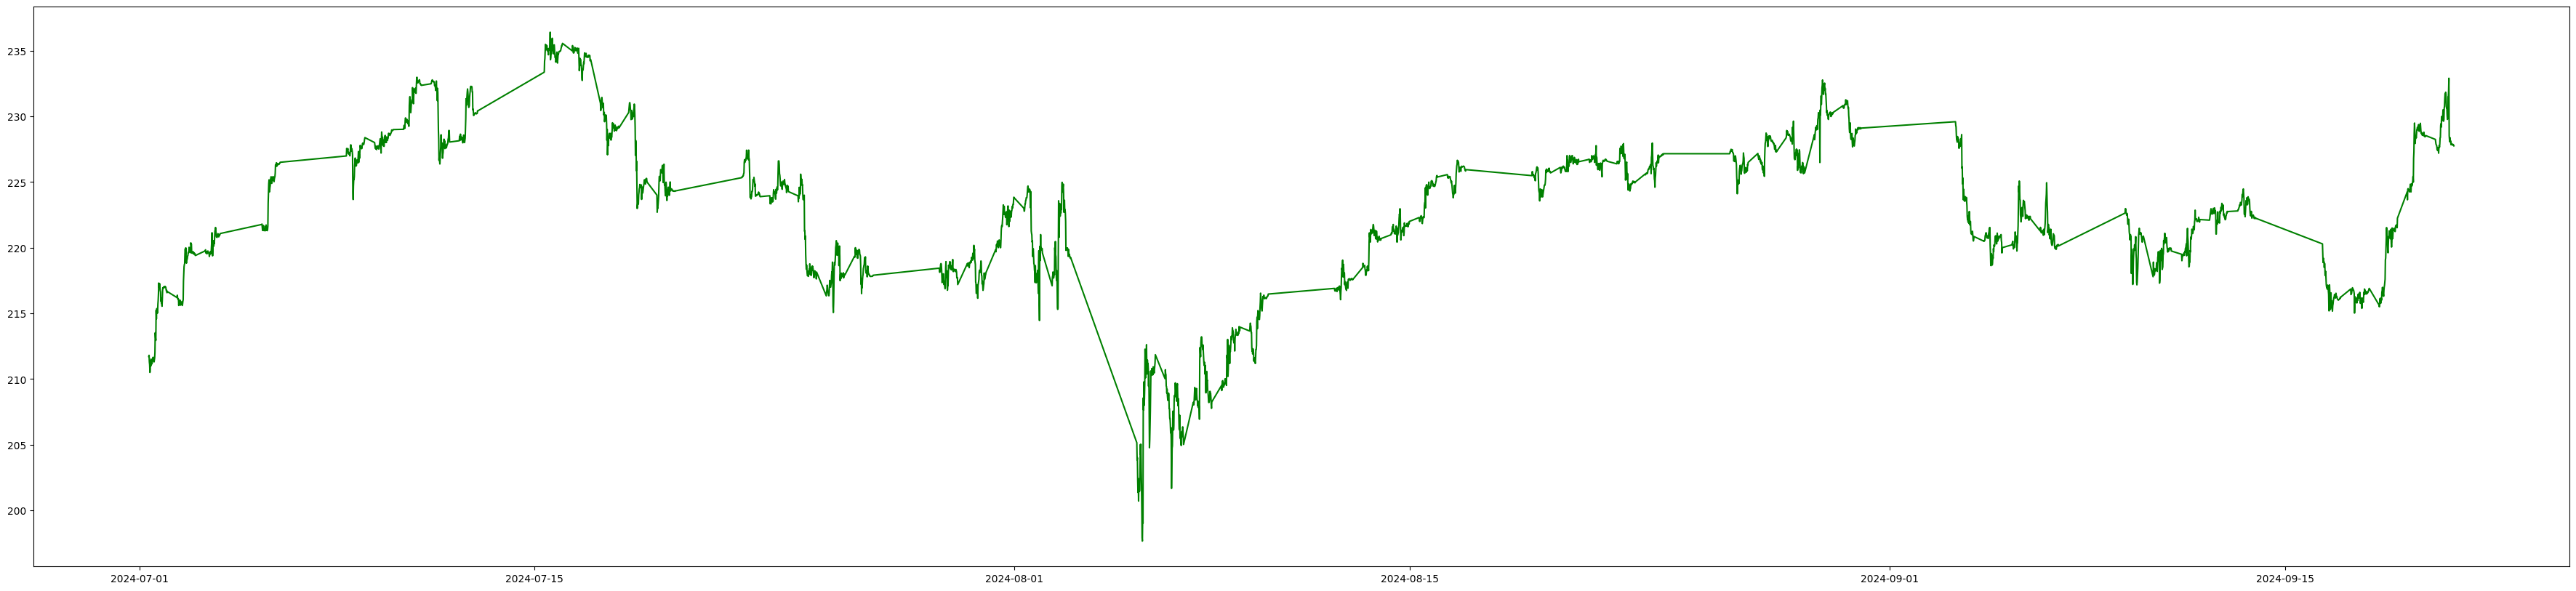

In [130]:
import matplotlib.pyplot as plt
import talib as ta
from datetime import datetime, timedelta
from historical_data.alpaca import AlpacaHistoricalData
from alpaca.data.timeframe import TimeFrameUnit

ticker = 'AAPL'
asset_type = 'Stock'
start_date = '2024-07-01'
end_date = '2024-09-22'
interval = 15
unit = TimeFrameUnit.Minute

alpaca_data = AlpacaHistoricalData(ticker, assetType=asset_type, start=start_date, end=end_date, interval=interval, unit=unit)
data = alpaca_data.get_data()
alpaca_data.plot_data()

In [131]:
from backtester.strategy import Strategy

class EMACrossoverLongStrategy(Strategy):
    def __init__(self, data):
        super().__init__(data)
        self.data['Short EMA'] = ta.EMA(self.data['Close'], short_period)
        self.data['Long EMA'] = ta.SMA(self.data['Close'], long_period)
        self.data['ATR'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], atr_period) # ATR is used for setting stop loss
        self.data['Previous Close'] = self.data['Close'].shift()
        bollinger_bands = ta.BBANDS(data['Close'], bb_period)
        self.data['Top Band'] = bollinger_bands[0]
        self.data['Middle Band'] = bollinger_bands[1]
        self.data['Bottom Band'] = bollinger_bands[2]
        self.count = 0
        self.data = self.data.dropna()
             
    def implement(self):
        self.data['Signal'] = 0

        for i in self.data.index:
            close_price = data.at[i, 'Close']
            if self.position == 'Standby':
                if self.count == 3:
                    buy_price = close_price
                    stop_loss = buy_price - (stop_loss_multiplier * self.data.at[i, 'ATR'])
                    self.position = 'Buy'
                    self.buy_trade(i, stop_loss=stop_loss)
                    self.data.at[i, 'Signal'] = 1
                    self.count = 0
                else:
                    if (close_price > self.data.at[i, 'Previous Close']):
                        self.count += 1
                    else:
                        self.position = 'Close'
                        self.count = 0            
            elif self.position == 'Close':
                if (close_price >= self.data.at[i, 'Top Band']) & \
                    (self.data.at[i, 'Short EMA'] > self.data.at[i, 'Long EMA']):
                    self.position = 'Standby'
            else:            
                if (self.data.at[i, 'Short EMA'] <= self.data.at[i, 'Long EMA']) | (self.data.at[i, 'Close'] <= self.stop_loss):
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'Close'
                else:
                    self.data.at[i, 'Signal'] = 1

    def plot_indicators(self):
        _, axis = plt.subplots(2, sharex=True, figsize=(45, 25))
        axis[0].set_title("Close Price Series with Crossovers") 
        axis[0].plot(self.data.index.get_level_values('timestamp'), self.data['Close'], color='black')
        axis[0].plot(self.data.index, self.data['Short EMA'], color='green')
        axis[0].plot(self.data.index, self.data['Long EMA'], color='blue')
        axis[0].grid()
        axis[1].set_title("Bollinger Bands") 
        axis[1].plot(self.data.index.get_level_values('timestamp'), self.data['Close'], color='black')
        axis[1].plot(self.data.index.get_level_values('timestamp'), self.data['Top Band'], color='blue')
        axis[1].plot(self.data.index.get_level_values('timestamp'), self.data['Bottom Band'], color='blue')
        axis[1].grid()
        plt.show()

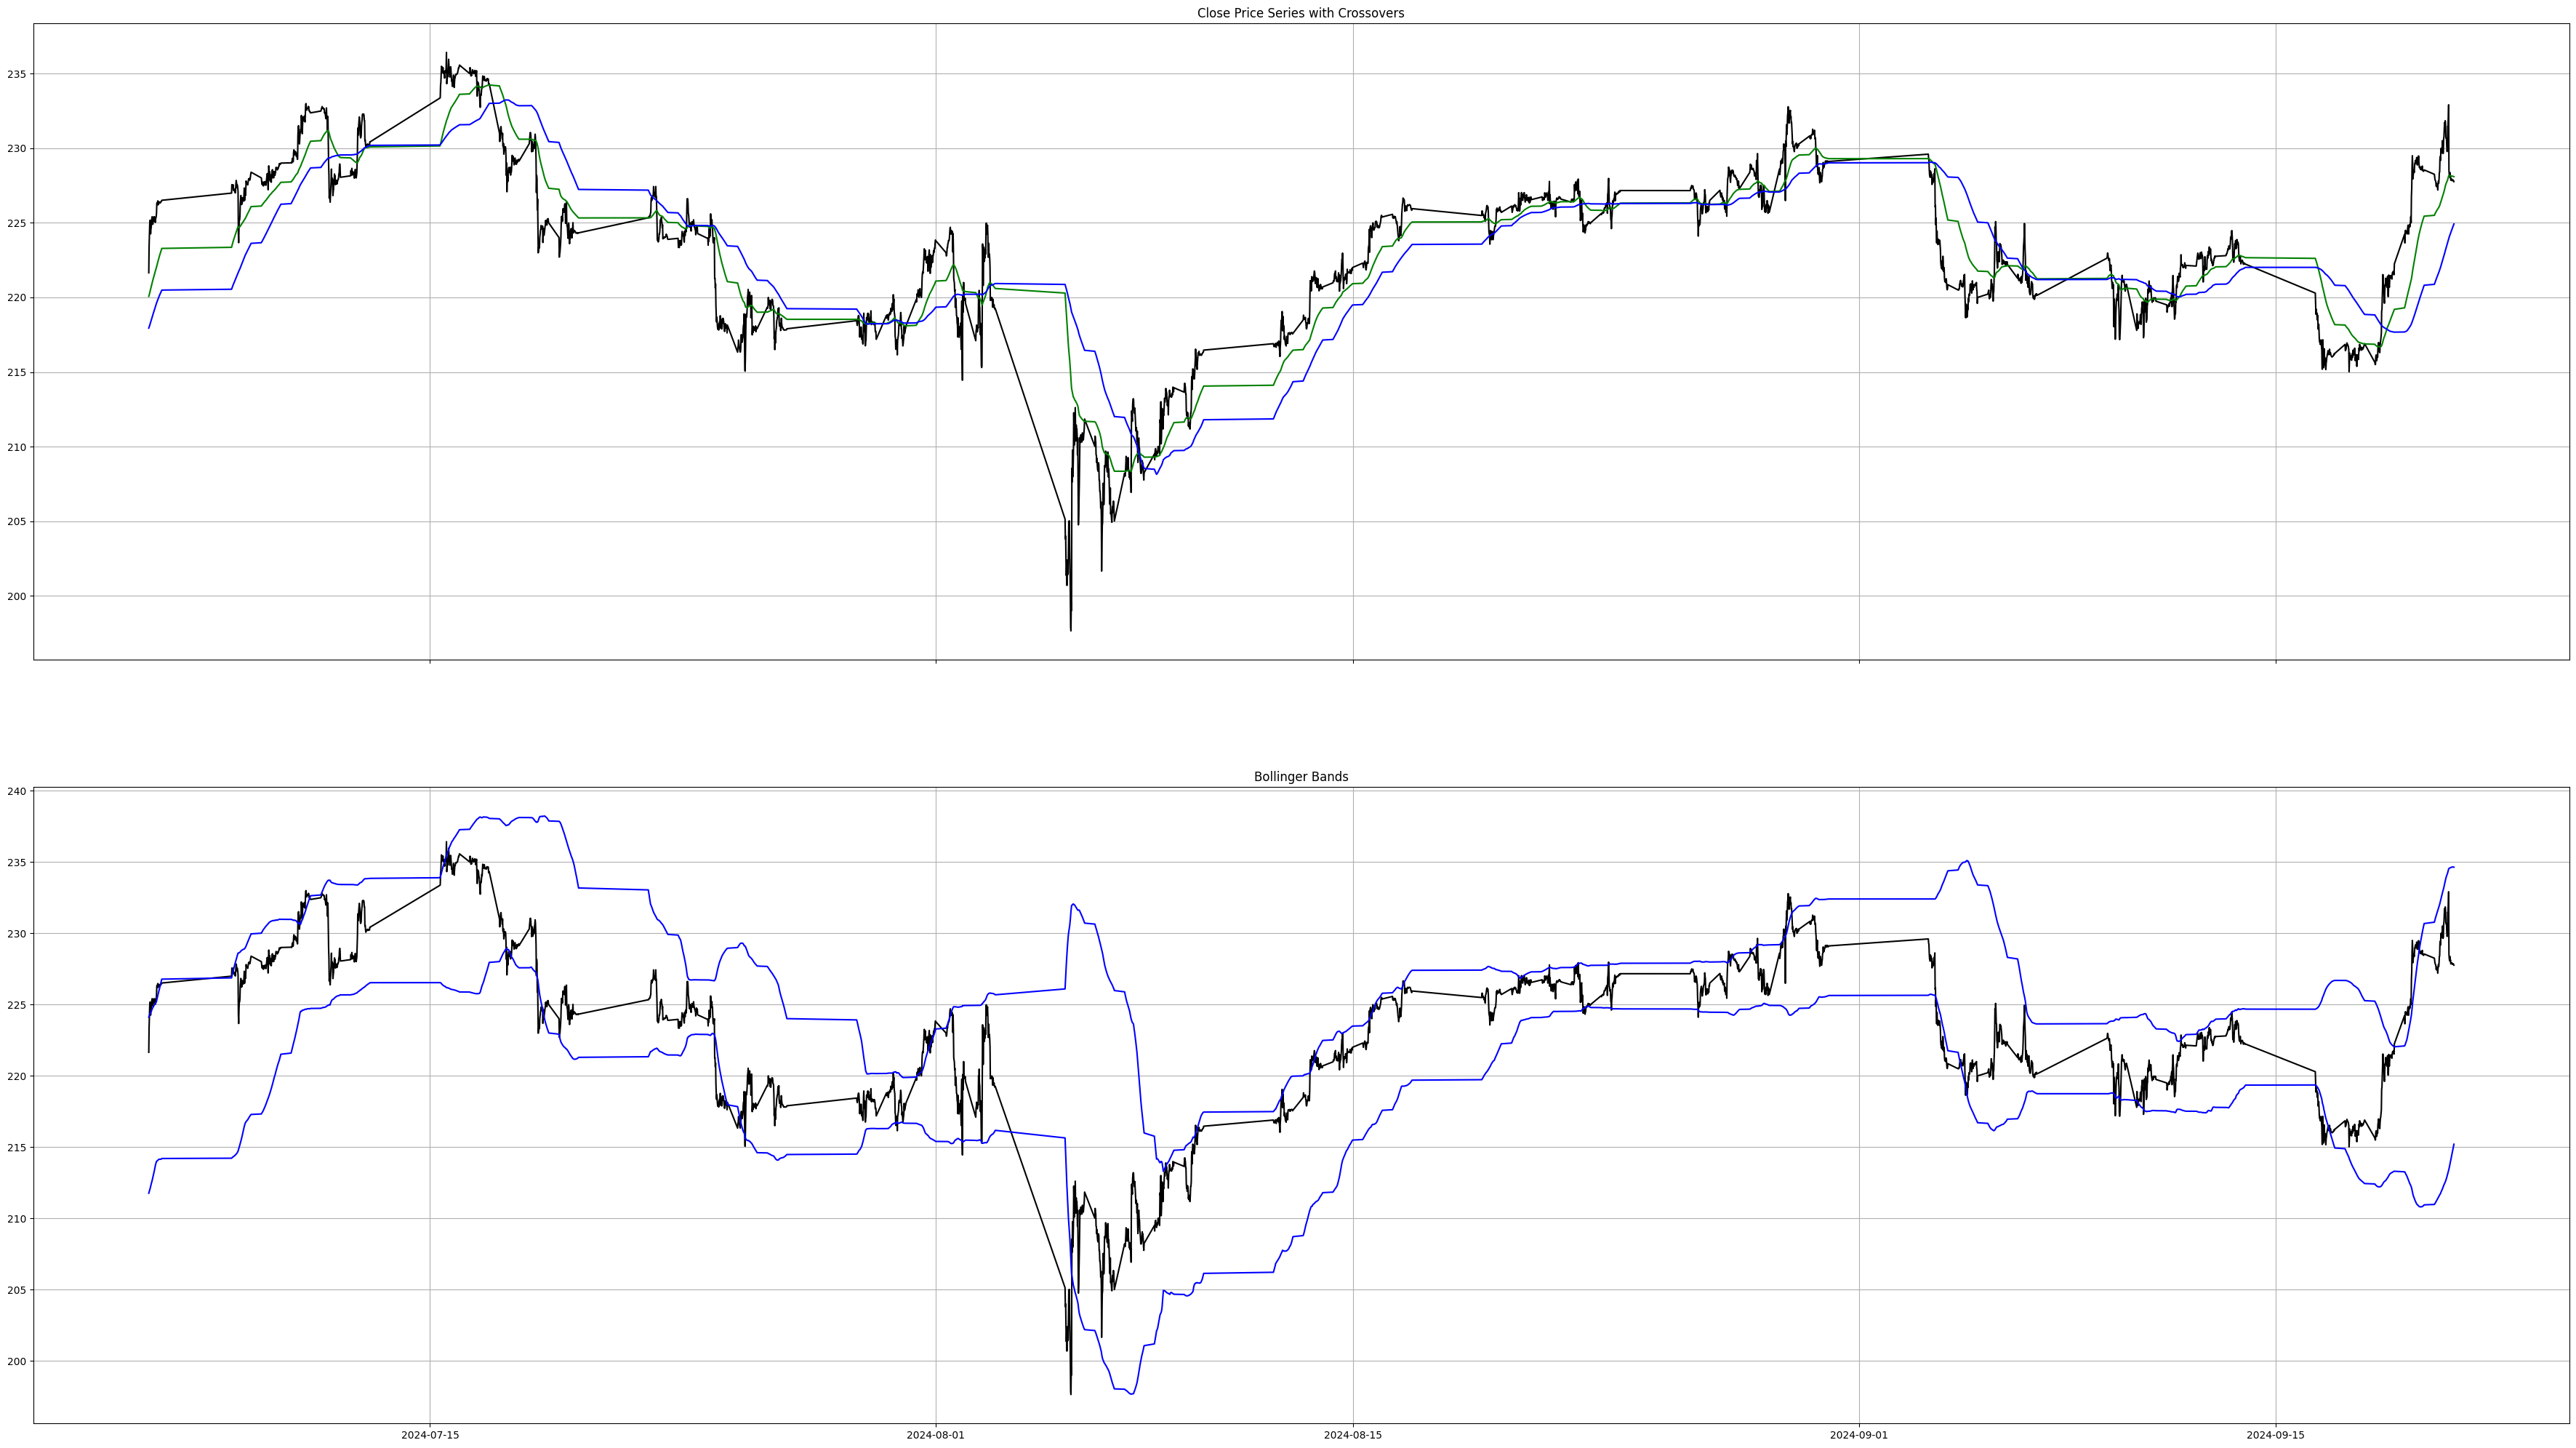

In [132]:
emaCrossover = EMACrossoverLongStrategy(data=data)
emaCrossover.plot_indicators()

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_99121/2315757732.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Signal'] = 0


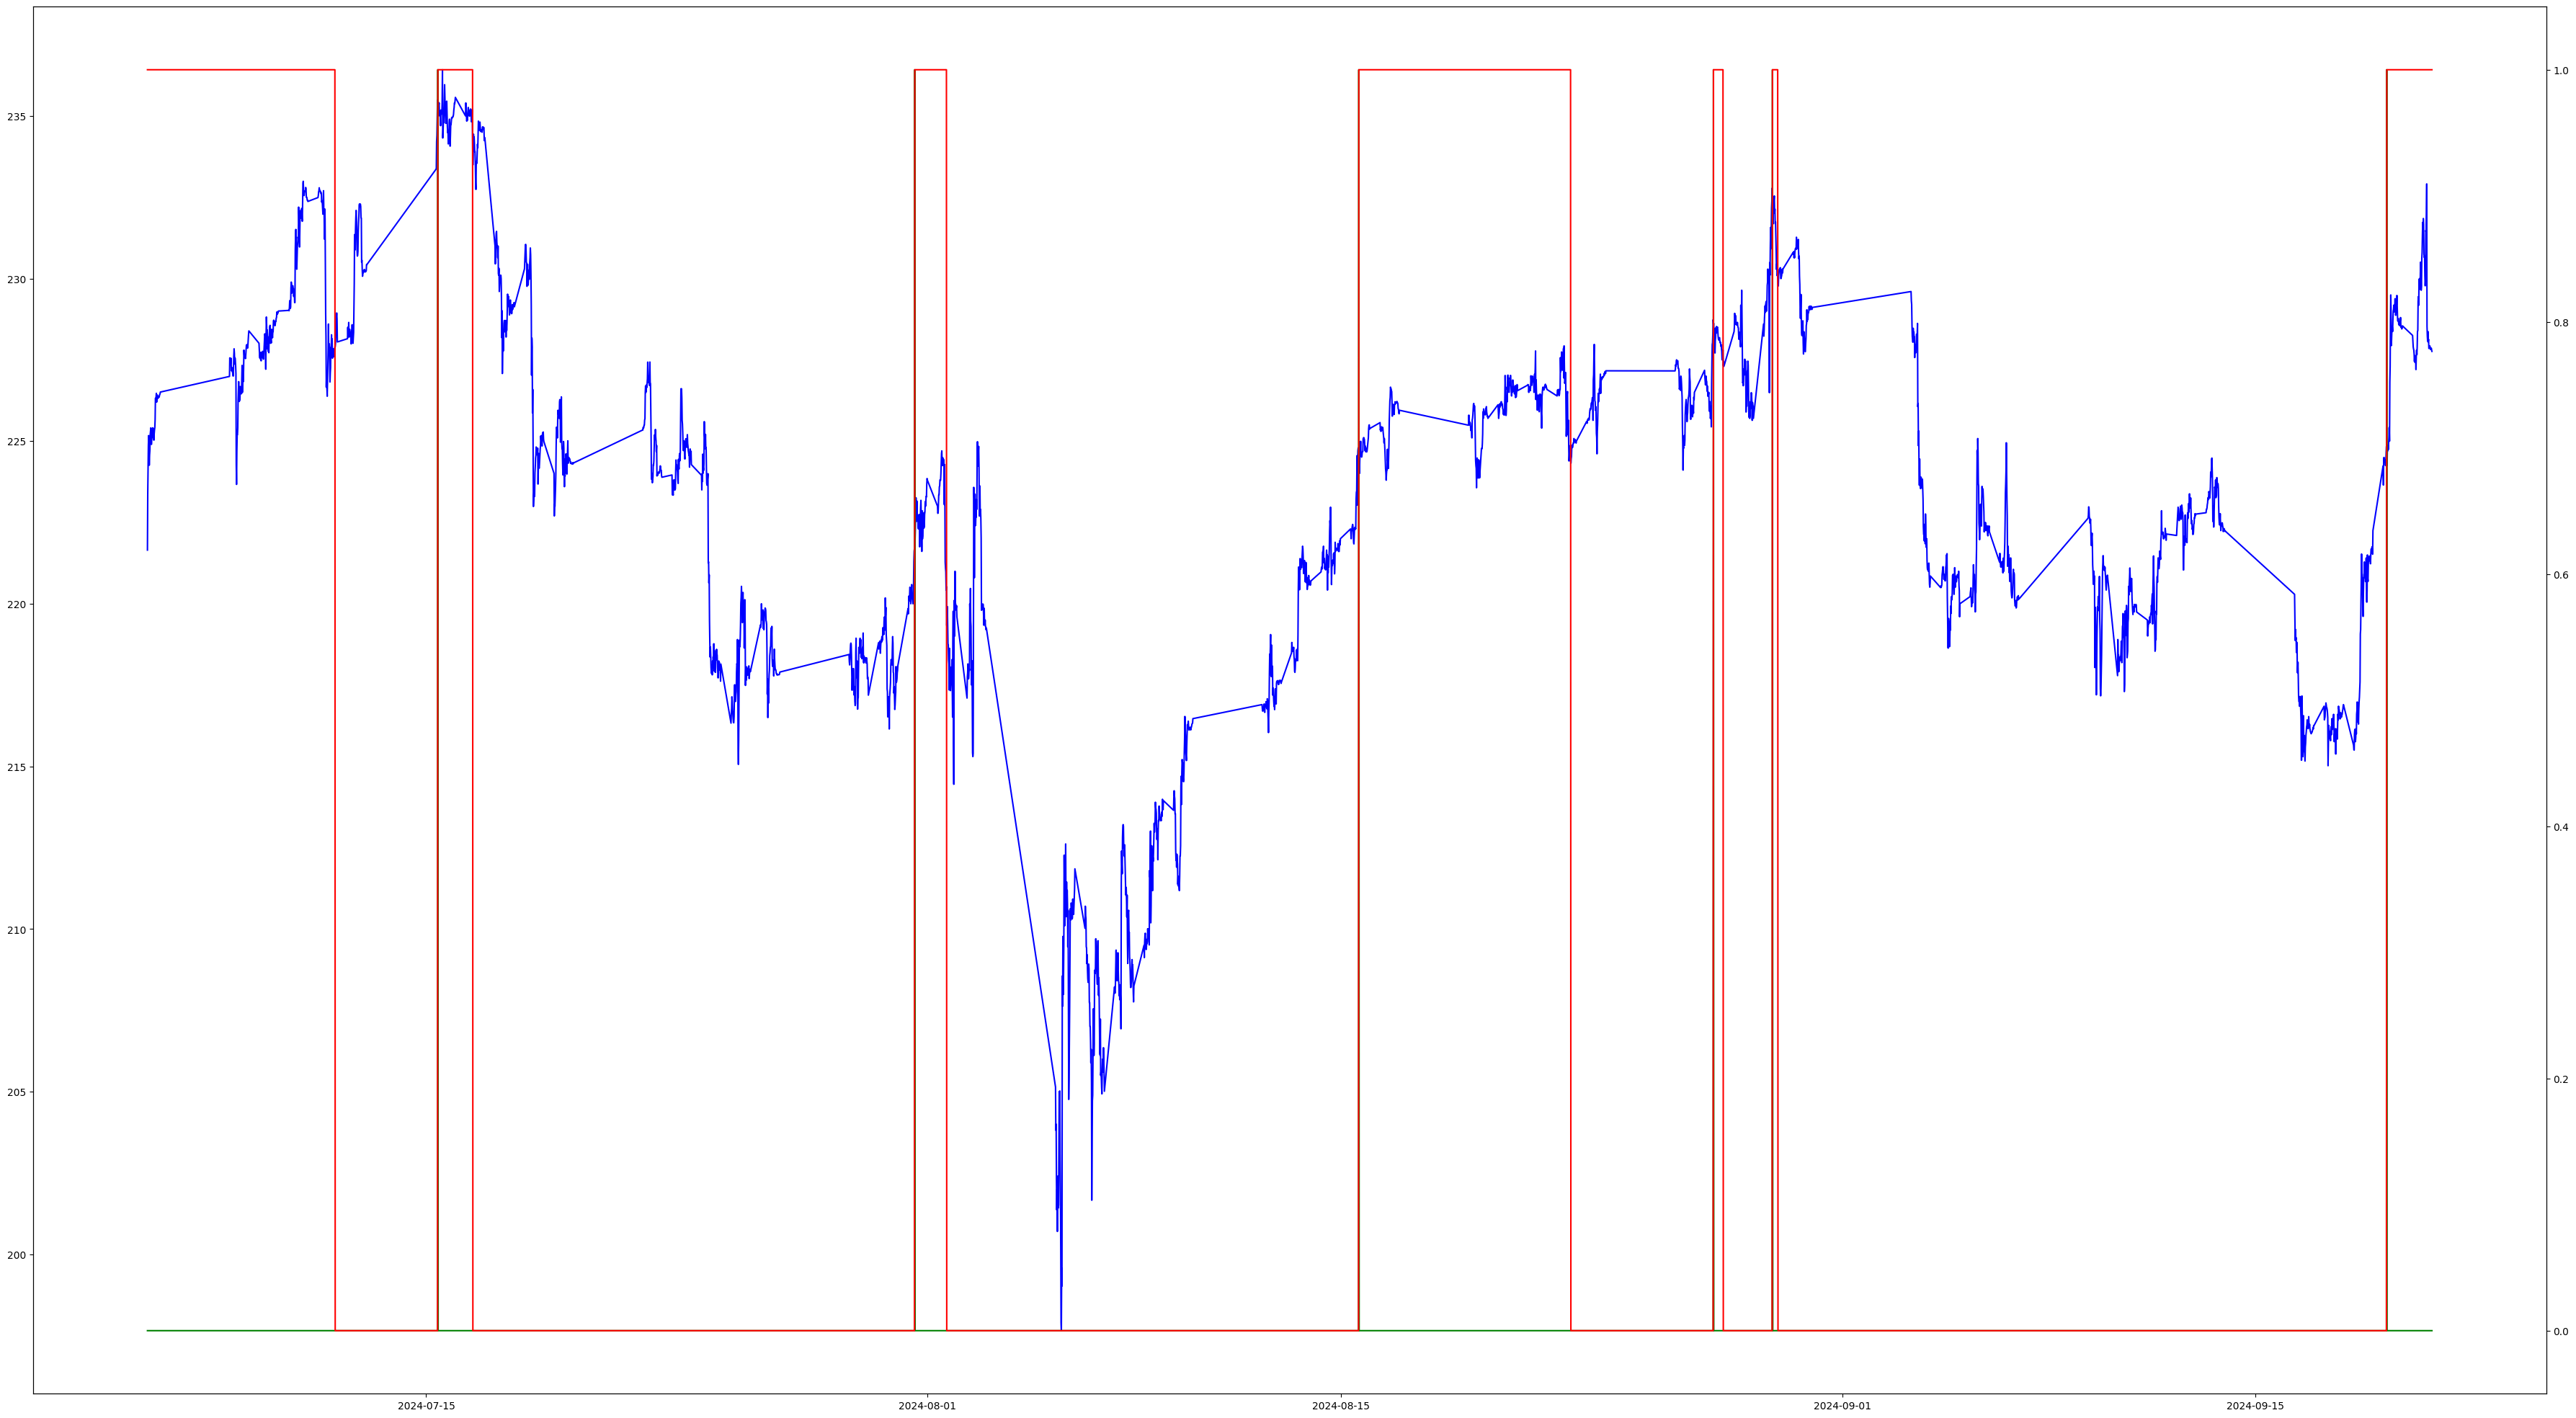

In [133]:
emaCrossover.implement()
emaCrossover.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '998.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.at[i, 'Cumulative Strategy Returns'] = cash


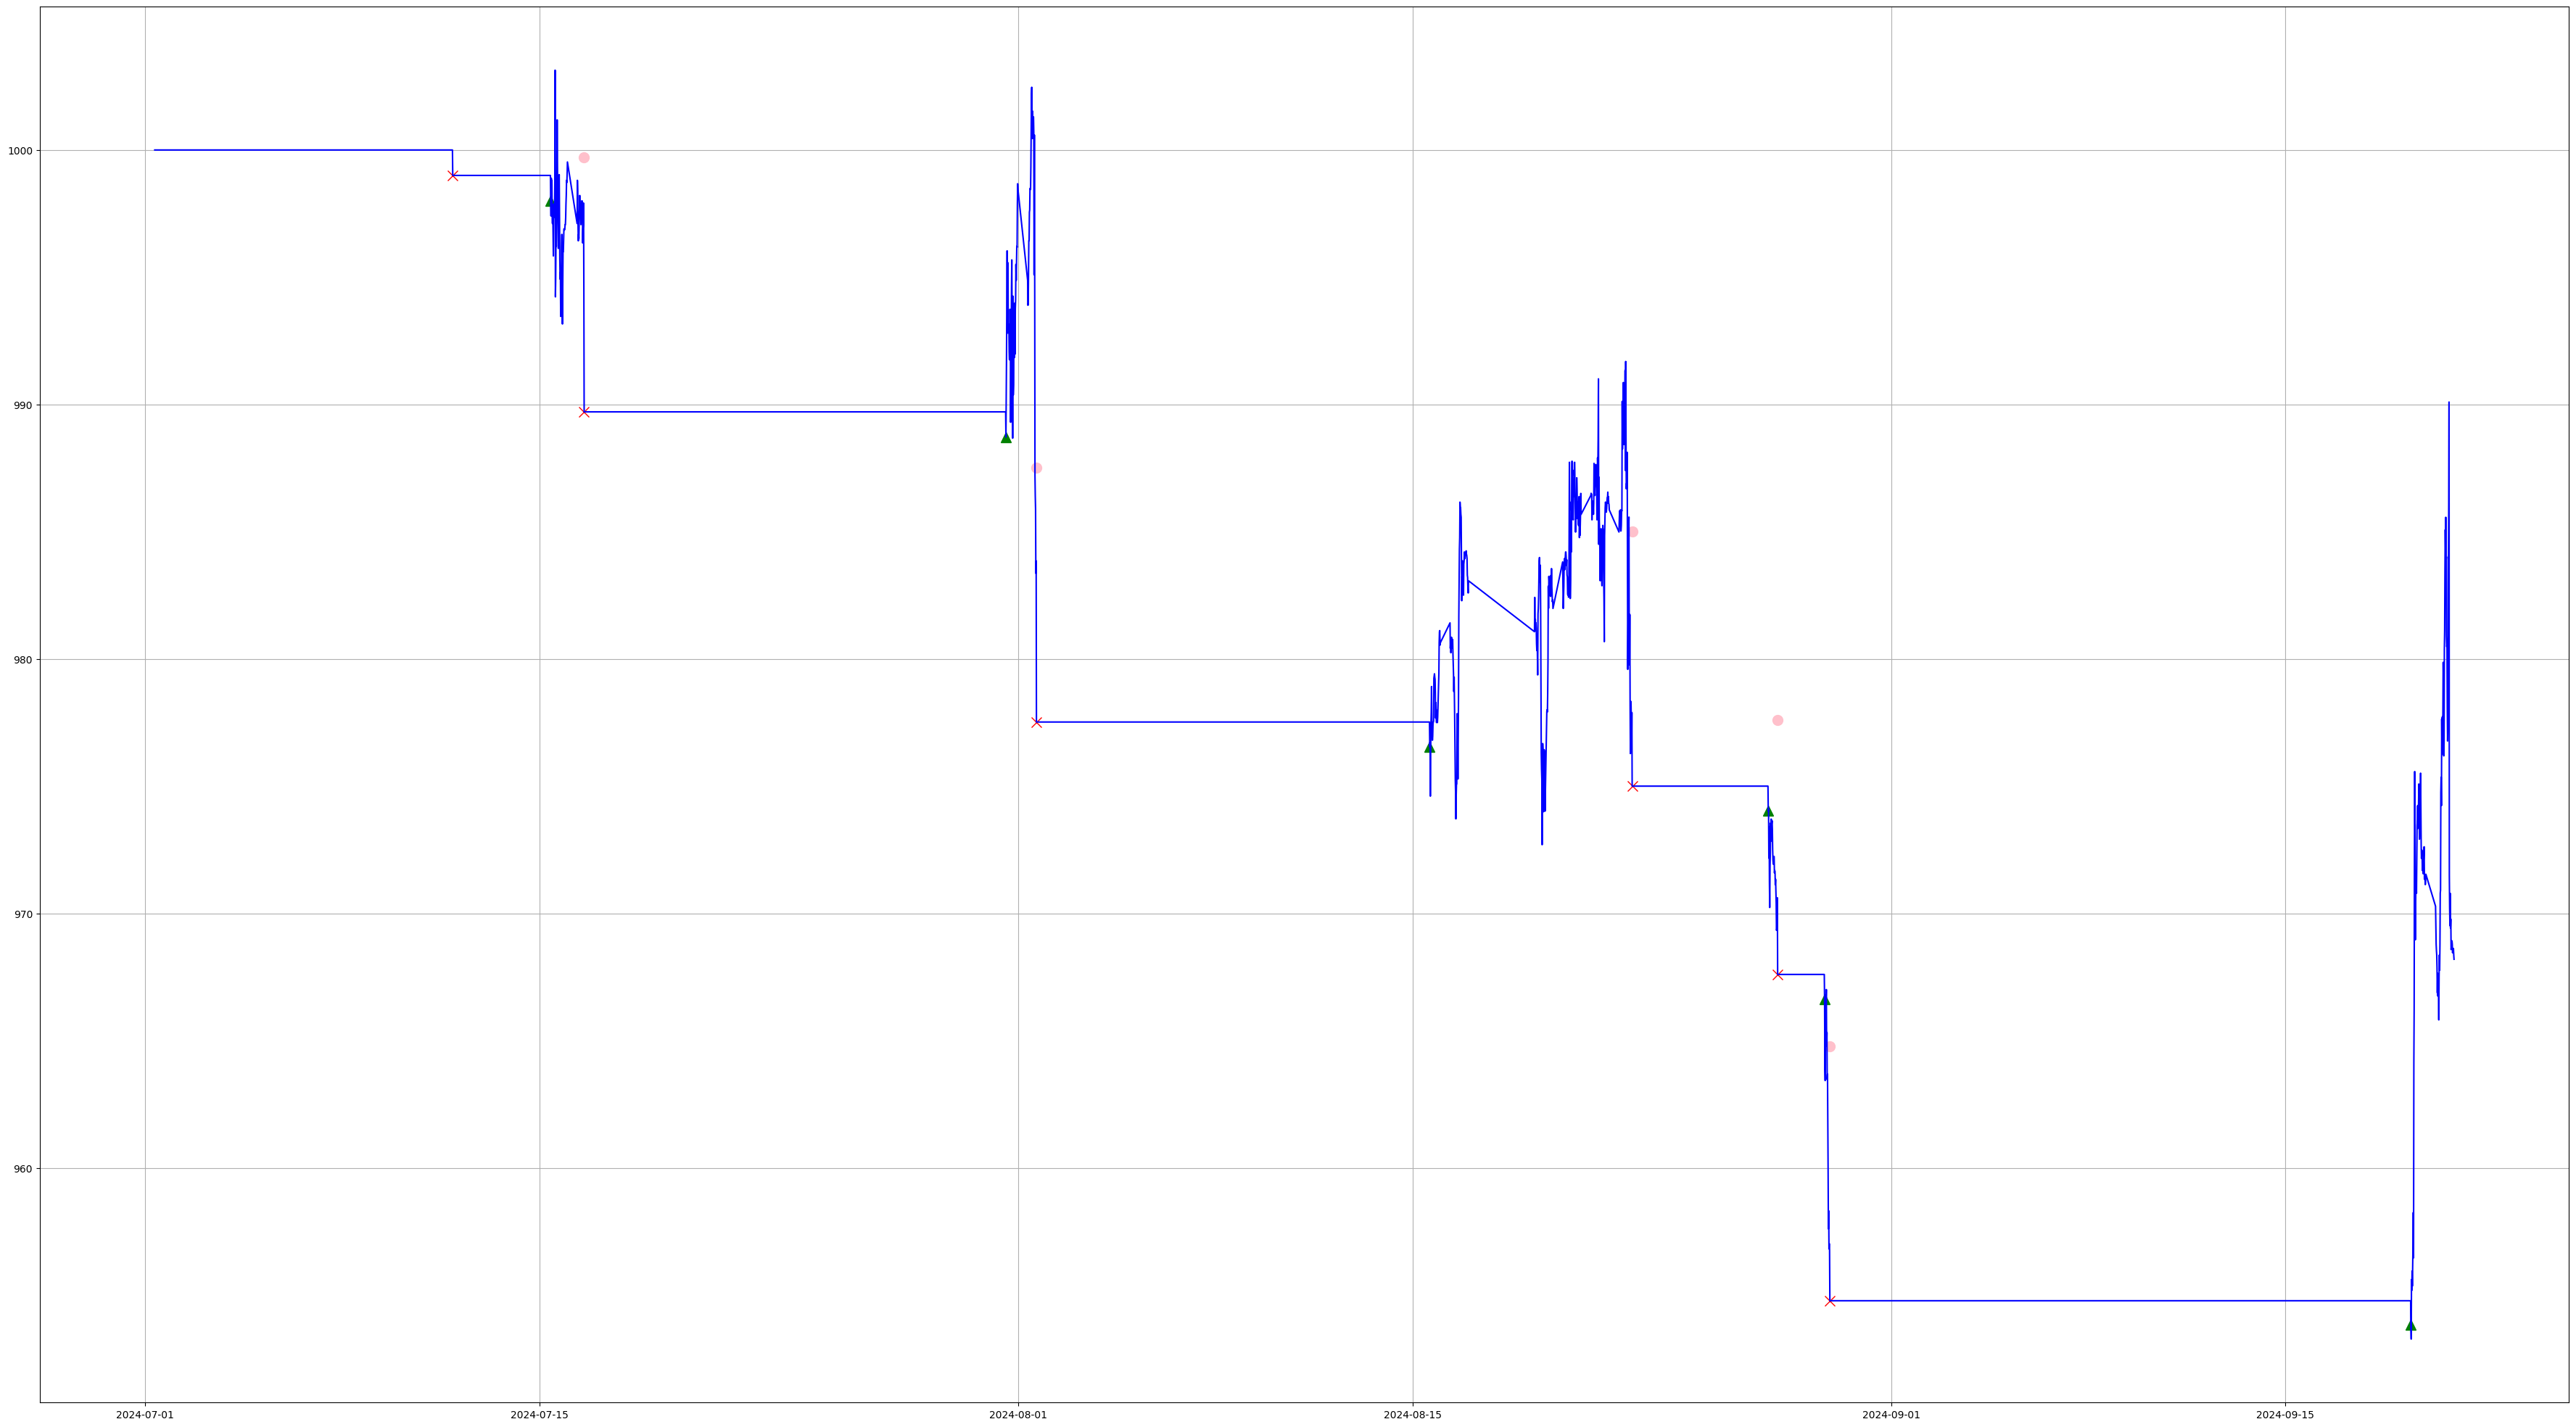

In [134]:
from backtester.backtester import Backtester


backtester = Backtester(emaCrossover, data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [135]:
backtester.get_metrics()

Final value:  968.2059225462657
P&L:  -31.794077453734303
Returns %:  -3.1794077453734304
Number of trades:  5
Loss trades %:  100.0
Profit trades %:  0.0
Annual Sharpe ratio:  -1.8048434713330412
Max profit %:  0.31350555673645886
Max loss %:  -4.671505913680994


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys